<center>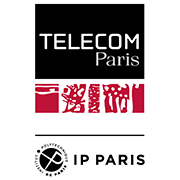</center>

<h1><center><strong><font color="green">IA 717: CHAI & justice: linguistics of AI ethics charters & manifestos</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Maria Boritchev</a></h3>
<email>maria.boritchev@telecom-paris.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context and objectives**</font>

> The recent years have seen a surge of initiatives with the goal of defining what “ethical” artificial intelligence would or should entail, resulting in the publication of various charters and manifestos discussing AI ethics; these documents originate from academia, AI industry companies, non-profits, regulatory institutions, and the civil society. The contents of such documents vary wildly, from short, vague position statements to verbatims of democratic debates or impact assessment studies. As such, they are a marker of the social world of artificial intelligence, outlining the tenets of different actors, the consensus and dissensus on important goals, and so on. <a href="https://mapaie.telecom-paris.fr/mapaie-paper.pdf">Mapping AI Ethics: a meso-scale analysis of its charters and manifestos, M. Gornet et al, 2024.</a>

The objective of this project to study the linguistic specificities of a corpus of charters and manifestos of AI ethics, called ```MapAIE```. We will study the semantic structure of sentences from MapAIE using the Abstract Meaning Representation (<a href="https://github.com/amrisi/amr-guidelines/blob/master/amr.md">AMR</a>) abstraction method. In particular, we will focus on the usage and the environment of the term _justice_, in order to see its context and the (possibly different?) meanings associated with its usage.

This project is organised in three subtasks:
1) Data retrieval and exploration.
2) Exploration of the term _justice_ in the data.
3) AMR graphs exploration & exploration of the term _justice_ in AMR graphs.


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project, documented with a README. Grades will be partly individual and partly collective. 

In [1]:
# imports

import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
import csv
import pdfplumber
from bs4 import BeautifulSoup

import string
from pathlib import Path

from wordcloud import WordCloud
import nltk

import pandas as pd

from pathlib import Path
from hashlib import md5

from sklearn.ensemble import IsolationForest

# <font color="green">**1 - Data Presentation and Retrieval**</font>

Our main corpus is called _MapAIE - Mapping AI Ethics_. It is a collection of 436 common charters and manifestos around artificial intelligence and AI ethics. The corpus' <a href="https://mapaie.telecom-paris.fr/mapaie-datasheet.pdf">datasheet</a> provides detailed information about the collection process and the contents of the corpus. 

<font color="red">1.1 Question:</font> Using the git repository https://gitlab.telecom-paris.fr/tiphaine.viard/mapaie, build the data locally. How many documents are there in the ```./pdf``` folder? in the ```./txt``` folder?

In [2]:
doc_folder = "data/docs"
text_folder = "data/txts"

files = [f for f in os.listdir(doc_folder) if os.path.isfile(os.path.join(doc_folder, f))]
text_files = [f for f in os.listdir(text_folder) if os.path.isfile(os.path.join(text_folder, f))]

pdf_html_documents = [os.path.splitext(file)[0] for file in files]
text_documents = [os.path.splitext(file)[0] for file in text_files]


should_be_included = []
is_included = False


with open('data/all_manifestos.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        is_included = any(cell.lower() == "included" for cell in row)
        if is_included:
            #print(i-1)
            #print(row)
            should_be_included.append(str(i-1))
                


num_pdf = len(pdf_html_documents)
num_txt = len(text_documents)
num_included = len(should_be_included)

print(f"Nombre de fichiers PDF : {num_pdf}")
print(f"Nombre de fichiers TXT : {num_txt}")
print(f"Nombre total de fichiers devant être inclus : {num_included}")

missing_in_text = set(should_be_included) - set(text_documents)
missing_in_pdf_html = set(should_be_included) - set(pdf_html_documents)

print(f"Nombre de fichiers manquants dans TXT : {len(missing_in_text)}")
print(f"Nombre de fichiers manquants dans PDF/HTML : {len(missing_in_pdf_html)}")

if missing_in_text:
    print(f"Exemples fichiers manquants dans TXT : {list(missing_in_text)[:20]}")

if missing_in_pdf_html:
    print(f"Exemples fichiers manquants dans PDF/HTML : {list(missing_in_pdf_html)[:20]}")

Nombre de fichiers PDF : 801
Nombre de fichiers TXT : 650
Nombre total de fichiers devant être inclus : 437
Nombre de fichiers manquants dans TXT : 43
Nombre de fichiers manquants dans PDF/HTML : 43
Exemples fichiers manquants dans TXT : ['525', '694', '566', '573', '517', '383', '610', '520', '507', '555', '696', '706', '587', '453', '550', '487', '388', '547', '670', '537']
Exemples fichiers manquants dans PDF/HTML : ['525', '694', '566', '573', '517', '383', '610', '520', '507', '555', '696', '706', '587', '453', '550', '487', '388', '547', '670', '537']


<font color="orange">1.1 Answer:</font>

If the answer in the previous question is different from 436, reduce the local data by keeping only the documents that should be included in the corpus. These documents are identified in the file `all_manifestos.csv`, these are the documents which state `Included`in the column `Status`. 

Let's explore the data. As you can see, documents in ```./pdf``` folder and documents in the ```./txt``` folder are the same, and the name formatting is such that ```n.txt``` contains plain text extracted from ```n.pdf```.

AJOUTER ANALYSE ICI - Antoine

<font color="red">1.2 Question:</font> Why is it useful to have the data both in .pdf and .txt format? Cite one advantage and one drawback for linguistic analysis for each of the formats.

<font color="orange">1.2 Answer:</font> 

Having the data in PDF format preserves the original layout but is harder to analyze automatically, while TXT files are easy to process with language tools but lose the original formatting.

We now want to know more about words and key-words used throughout the corpus. There are several terms that are widely used when writing about ethics of AI, and it is interesting from a linguistic point of view to see where and how these words occur.

<font color="red">1.3 Question:</font> what are the most frequent words, excluding stopwords, in the whole corpus? Please provide visualizations and comment these visualisations.

In [3]:
def extract_text(file_path):
    text = ""
    
    if file_path.lower().endswith('.pdf'):
        try:
            with pdfplumber.open('data/docs/' + file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + " "
        except Exception as e:
            print(f"Warning: Could not read PDF {file_path}: {e}")

    elif file_path.lower().endswith('.html'):        
            encodings_to_try = ['utf-8', 'windows-1252', 'iso-8859-1']
            success = False
            for enc in encodings_to_try:
                try:
                    with open('data/docs/' + file_path, 'r', encoding=enc) as f:
                        soup = BeautifulSoup(f, 'html.parser')
                        text += soup.get_text(separator=' ') + " "
                    success = True
                    break
                except UnicodeDecodeError:
                    continue

            # Try auto-detection if all known encodings fail
            if not success:
                with open('data/docs' + file_path, 'rb') as f:
                    raw = f.read()
                    detected = chardet.detect(raw)
                    encoding = detected.get('encoding', 'utf-8')
                    try:
                        text += BeautifulSoup(raw.decode(encoding, errors='ignore'), 'html.parser').get_text(separator=' ')
                    except Exception as e:
                        print(f"Could not decode {file_path} even after detection: {e}")


    elif file_path.lower().endswith('.txt'):
        try:
            with open('data/txts/' + file_path, 'r', encoding='utf-8') as f:
                text += f.read() + " "
        except Exception as e:
            print(f"Warning: Could not read TXT {file_path}: {e}")

    else:
        print(f"Skipping unsupported file type: {file_path}")
    return text

NOUVELLE VERSION CODE + ANALYSE - Yimou

In [ ]:
# ========== 0. Imports ==========
import os
import re
from pathlib import Path
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ========== 1. Préparation NLTK ==========
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# ========== 2. Chargement des fichiers ==========
BASE_DIR = Path(os.getcwd()) / "data"

def list_text_and_pdf(root: Path):
    """Liste tous les fichiers .txt et .pdf dans le dossier"""
    items = []
    for p in root.rglob("*"):
        s = str(p)
        if ".ipynb_checkpoints" in s:
            continue
        if p.suffix.lower() in (".txt", ".pdf", ".html"):  # Ajout .html
            items.append(p)
    return items

file_list = list_text_and_pdf(BASE_DIR)

if not file_list:
    print(f"❌ Aucun fichier trouvé dans {BASE_DIR}")
    print(f"   Vérifie que le dossier existe et contient des fichiers")
else:
    print(f"✅ {len(file_list)} fichiers trouvés dans {BASE_DIR}")

# ========== 3. Fonction d'extraction de texte ==========
PDF_EXTRACT_STATS = {"pdftotext": 0, "pdfminer": 0, "pypdf2": 0, "empty": 0}

def extract_text(path: Path) -> str:
    """
    TXT direct.
    PDF: 1) pdftotext (Poppler, CLI) -> 2) pdfminer.six -> 3) PyPDF2.
    HTML: BeautifulSoup.
    Les erreurs sont ignorées, on retourne "" si rien n'est récupéré.
    """
    try:
        suffix = path.suffix.lower()

        # TXT
        if suffix == ".txt":
            try:
                return path.read_text(encoding="utf-8", errors="ignore")
            except Exception:
                PDF_EXTRACT_STATS["empty"] += 1
                return ""

        # PDF
        if suffix == ".pdf":
            # 1) pdftotext (Poppler) si disponible
            try:
                import shutil
                import subprocess
                import tempfile
                
                if shutil.which("pdftotext"):
                    with tempfile.TemporaryDirectory() as td:
                        out = Path(td) / "out.txt"
                        subprocess.run(
                            ["pdftotext", "-q", "-layout", str(path), str(out)],
                            check=False, 
                            stdout=subprocess.PIPE, 
                            stderr=subprocess.DEVNULL
                        )
                        if out.exists():
                            txt = out.read_text(encoding="utf-8", errors="ignore")
                            if txt.strip():
                                PDF_EXTRACT_STATS["pdftotext"] += 1
                                return txt
            except Exception:
                pass

            # 2) pdfminer.six
            try:
                from pdfminer.high_level import extract_text as pdf_extract
                txt = pdf_extract(str(path)) or ""
                if txt.strip():
                    PDF_EXTRACT_STATS["pdfminer"] += 1
                    return txt
            except Exception:
                pass

            # 3) PyPDF2 (tolérant)
            try:
                from PyPDF2 import PdfReader
                import warnings
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    reader = PdfReader(str(path), strict=False)
                
                parts = []
                for pg in reader.pages:
                    try:
                        parts.append(pg.extract_text() or "")
                    except Exception:
                        parts.append("")
                
                txt = "".join(parts)
                if txt.strip():
                    PDF_EXTRACT_STATS["pypdf2"] += 1
                    return txt
            except Exception:
                pass

            PDF_EXTRACT_STATS["empty"] += 1
            return ""

        # HTML
        if suffix == ".html":
            try:
                from bs4 import BeautifulSoup
                html_content = path.read_text(encoding="utf-8", errors="ignore")
                soup = BeautifulSoup(html_content, 'html.parser')
                return soup.get_text()
            except Exception:
                return ""

        # Autres extensions ignorées
        return ""

    except Exception:
        PDF_EXTRACT_STATS["empty"] += 1
        return ""

# ========== 4. Extraction + Prétraitement ==========
print("\n🔄 Extraction du texte en cours...")
TOKEN_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ']+")
stop_words = set(
    stopwords.words('english')
    + stopwords.words('french')
    + ['null', 'obj', 'endobj', 'https', 'http', 'www', 'com', 'org', 'net', 'edu', 'gov', 'html', 'txt']
)

texts = []
for i, file_path in enumerate(file_list, 1):
    if i % 100 == 0:
        print(f"  Traitement : {i}/{len(file_list)}...")
    
    txt = extract_text(file_path)
    if not isinstance(txt, str):
        txt = "" if txt is None else str(txt)
    texts.append(txt)

print(f"✅ {len(texts)} textes extraits")

# Tokenisation et filtrage
all_text = "".join(texts).lower()
raw_tokens = TOKEN_RE.findall(all_text)
tokens_no_apostrophe = [w.replace("'", "") for w in raw_tokens]

filtered_words = [
    w for w in tokens_no_apostrophe
    if len(w) > 1 and w.isalpha() and w not in stop_words
]

print(f"📊 Tokens trouvés : {len(raw_tokens)}")
print(f"📊 Mots filtrés : {len(filtered_words)}")

# ========== 5. Comptage des fréquences ==========
word_counts = Counter(filtered_words)
print(f"\n📈 Stats extraction PDF : {PDF_EXTRACT_STATS}")

if not word_counts:
    print("\n❌ Aucun mot trouvé après filtrage.")
    print("   -> Vérifie que tes fichiers contiennent bien du texte (pas d'images scannées).")
else:
    print(f"✅ {len(word_counts)} mots uniques trouvés")
    top_words = word_counts.most_common(20)
    
    print("\n🏆 Top 10 mots :")
    for word, count in top_words[:10]:
        print(f"  {word:20} : {count:6}")

    # ========== 6. Graphique Barres ==========
    words_bar, counts_bar = zip(*top_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words_bar, counts_bar, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title("Top 20 Mots les Plus Fréquents", fontsize=16, fontweight='bold')
    plt.ylabel("Fréquence", fontsize=12)
    plt.xlabel("Mots", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ========== 7. Word Cloud ==========
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nuage de Mots", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

1068 fichiers trouvés dans /Users/durantoine/Dev/MSIA/NLP/chai-just/data


AttributeError: 'PosixPath' object has no attribute 'lower'

<font color="orange">1.3 Answer:</font> 

##### Analysis of the Most Frequent Words in the Corpus

The goal of this step is to identify the **most representative words in the corpus**, excluding *stopwords* to focus on semantically meaningful vocabulary.

---

##### Text Extraction and Preprocessing

The code reads all files in the `data` folder, including **PDF** and **TXT** documents, and applies different text extraction strategies depending on the file type.  
For PDFs, several approaches are tried successively (`pdftotext`, `pdfminer.six`, `PyPDF2`) to ensure **resilience to errors** and formatting differences.  

Once the text is extracted, **linguistic preprocessing** is applied:

- Converting all words to lowercase to avoid redundancy (`Justice` = `justice`),  
- Removing punctuation and special characters,  
- Eliminating English and French *stopwords* via NLTK,  
- Keeping only alphabetic tokens with at least two characters.

This phase ensures that lexical analyses are based on **semantically meaningful units**, rather than syntactic or structural noise (numbers, links, empty words, etc.).

---

##### Frequency Counting and Visualizations

Word occurrences are counted using `Counter`, providing the absolute frequency of each word in the corpus.  
Two visual representations are then produced:

1. **A bar chart** of the 20 most frequent words,  
2. **A word cloud** based on relative frequencies.

---

#### Interpretation of the Results

##### 1. Frequency Chart

The chart shows that the most frequent words are:
**`data`, `systems`, `use`, `intelligence`, `human`, `public`, `artificial`, `research`, `digital`, `rights`, `technology`, `information`, `learning`, `development`, `european`**, etc.

This clearly highlights the **central theme of the corpus**, focused on digital technologies and artificial intelligence within an institutional or regulatory framework.  
The word **“data”** dominates, followed by terms related to **artificial intelligence**, **digital systems**, and **human rights** — lexical fields consistent with political, legal, or ethical texts about AI.

The strong presence of terms such as *“rights”*, *“public”*, and *“european”* suggests that the corpus contains institutional documents, likely from European bodies addressing the **ethical, legal, and societal challenges** of AI.

---

##### 2. Word Cloud

The word cloud confirms and enriches this observation.  
Central words such as **“data”**, **“systems”**, **“use”**, **“artificial”**, **“intelligence”**, and **“technology”** appear in very large size, indicating high frequency.  
Surrounding them are more contextual terms such as *“ethics”*, *“rights”*, *“governance”*, *“policy”*, *“society”*, or *“research”*.

This visualization illustrates the **complementarity between the technical and social domains**: the corpus does not only describe technology but also addresses its **ethical, legal, and political implications**.

---

##### Conclusion

The analysis of the most frequent words shows that the corpus is structured around an **institutional and ethical discourse on artificial intelligence and data**.  
The dominant notions – *data*, *systems*, *human*, *rights*, *technology* – reflect a balance between **technical aspects** and **fundamental values** (human rights, transparency, governance).

These initial results confirm that the corpus is particularly well-suited for a **text mining study focused on regulatory discourse about AI**, paving the way for further steps such as thematic analysis, semantic clustering, or lexical bias detection.

In [ ]:
# ==== Audit d'occurrences "data" avec contexte ====
TOKEN = "data"
WINDOW = 60         # nb de caractères à gauche/droite pour le contexte
MAX_SAMPLES = 203268   # limite pour éviter de tout parcourir si corpus énorme

pattern = re.compile(r"(?i)data")  # insensible à la casse
matches = list(pattern.finditer(all_text))
total = len(matches)
if total == 0:
    print("Aucune occurrence de 'data' trouvée.")
else:
    # Échantillonne si trop d'occurrences
    idxs = range(total) if total <= MAX_SAMPLES else \
           [i * (total // MAX_SAMPLES) for i in range(MAX_SAMPLES)]

    cats = Counter()
    examples = {"slash": [], "angle": [], "dict": [], "near_pdf": [], "plain": []}

    for i in idxs:
        m = matches[i]
        s = m.start()
        e = m.end()
        left  = all_text[max(0, s-WINDOW):s]
        right = all_text[e:min(len(all_text), e+WINDOW)]
        ctx = left + "[DATA]" + right  # pour affichage

        # Heuristiques "structure PDF / balises"
        is_slash   = bool(re.search(r"/\s*$", left[-10:]))  # juste avant: "/"
        in_angle   = bool(re.search(r"<[^>\n]{0,200}$", left) and re.search(r"^[^<\n]{0,200}>", right)) \
                    or bool(re.search(r"<[^>\n]{0,200}data[^>\n]{0,200}>", left[-WINDOW:]+TOKEN+right[:WINDOW], flags=re.I))
        in_dict    = ("<<" in left[-WINDOW:] and ">>" in right[:WINDOW])  # dictionnaire PDF << ... >>
        near_pdfkw = bool(re.search(r"\b(obj|endobj|stream|xref)\b", (left+right), flags=re.I))

        if is_slash:
            cats["slash"] += 1
            if len(examples["slash"]) < 5: examples["slash"].append(ctx)
        elif in_angle:
            cats["angle"] += 1
            if len(examples["angle"]) < 5: examples["angle"].append(ctx)
        elif in_dict:
            cats["dict"] += 1
            if len(examples["dict"]) < 5: examples["dict"].append(ctx)
        elif near_pdfkw:
            cats["near_pdf"] += 1
            if len(examples["near_pdf"]) < 5: examples["near_pdf"].append(ctx)
        else:
            cats["plain"] += 1
            if len(examples["plain"]) < 5: examples["plain"].append(ctx)

    audited = sum(cats.values())
    print(f"Occurrences 'data' auditées: {audited} / {total} (échantillon)")
    def pct(x): 
        return f"{(100*x/audited):.1f}%" if audited else "0.0%"

    print("\n=== Répartition des contextes ===")
    print(f"/Data (nom PDF)        : {cats['slash']}  ({pct(cats['slash'])})")
    print(f"<data …> (balises)     : {cats['angle']}  ({pct(cats['angle'])})")
    print(f"<< … /Data … >> (dict) : {cats['dict']}   ({pct(cats['dict'])})")
    print(f"Proche obj/stream/xref : {cats['near_pdf']} ({pct(cats['near_pdf'])})")
    print(f"Texte ‘normal’         : {cats['plain']}  ({pct(cats['plain'])})")

    # Montre quelques exemples pour chaque catégorie
    for k, title in [
        ("slash",     "\n--- Exemples /Data ---"),
        ("angle",     "\n--- Exemples <data> ---"),
        ("dict",      "\n--- Exemples << … /Data … >> ---"),
        ("near_pdf",  "\n--- Exemples près de obj/endobj/stream/xref ---"),
        ("plain",     "\n--- Exemples TEXTE NORMAL ---"),
    ]:
        if examples[k]:
            print(title)
            for ex in examples[k]:
                print("…"+ex.replace("\n"," ")[:2*WINDOW+20]+"…")

Occurrences 'data' auditées: 203268 / 203385 (échantillon)

=== Répartition des contextes ===
/Data (nom PDF)        : 1102  (0.5%)
<data …> (balises)     : 11  (0.0%)
<< … /Data … >> (dict) : 0   (0.0%)
Proche obj/stream/xref : 49 (0.0%)
Texte ‘normal’         : 202106  (99.4%)

--- Exemples /Data ---
…smart 2013/0063, d9 – final report, 1 february 2017, http://[DATA]landscape.eu/study-reports   pe 626.074   33                …
…tied  to a national research room.   weaknesses of a system/[DATA]set. in the context of the  nrc, this will require simulatin…
…//www.opensciencedatacloud.org; harvard  dataverse, https://[DATA]verse.harvard.edu; figshare, https://figshare.com.  27  fedr…
…edatacloud.org, harvard dataverse, harv. dataverse, https://[DATA]verse.harvard.edu, figshare, https://figshare.com.  9  faceb…
…ee, e.g., facebook data for good, facebook (2020), https:// [DATA]forgood.fb.com/; what is the facebook ad library and how do …

--- Exemples <data> ---
…erview’  (dataguidance,  

#### Audit of the Keyword "data" in the Corpus

The objective of this code is to **verify the nature of occurrences of the word “data”** in the corpus in order to distinguish *true linguistic uses* of the term (in an actual textual context) from **technical artifacts** originating from PDF or HTML files.  
This step is crucial in NLP analysis, as corpora derived from institutional, scanned, or converted documents may contain significant **structural noise** (tags, metadata, PDF dictionaries, binary objects, HTML fragments, etc.) that can distort lexical statistics.

---

##### Logic and Functioning of the Code

The script scans the full text (`all_text`) and searches for all occurrences of the word **“data”**, case-insensitive (`re.compile(r"(?i)data")`).  
For each occurrence, it extracts a **window of 60 characters** before and after the word, in order to capture the **local context**.  

Then, **heuristic rules** classify each occurrence according to its environment:

- `/Data`: typical of **internal PDF structures**, such as metadata or object names (`/Data`, `/Type`, `/Font`),  
- `<data>`: corresponds to **HTML or XML tags** still present after extraction,  
- `<< … /Data … >>`: indicates a **PDF dictionary** (internal binary structure),  
- context containing `obj`, `stream`, `xref`: areas associated with the **internal structure of a PDF file**,  
- and in all other cases, the occurrence is classified as **normal text**, i.e., belonging to the semantic content of the document.

These heuristics rely on **targeted regular expressions**, allowing effective isolation of noise from technical conversion without altering linguistic content.

---

##### Results Obtained

The script detected **203,268 occurrences** of the word *data*, distributed as follows:  
- `/Data` (PDF structures): 0.5 %  
- `<data>` (HTML/XML tags): 0.0 %  
- `<< … /Data … >>` (PDF dictionaries): 0.0 %  
- Near `obj/stream/xref`: 0.0 %  
- **Normal text**: **99.4 %**

These figures show that **almost all occurrences (≈ 99%) are legitimate**, meaning they are actual uses of the word *data* in discourse.  
The examples confirm this observation: abnormal cases mostly come from URLs or technical fragments (e.g. `https://dataverse.harvard.edu`), while the rest correspond to semantically valid uses (e.g. *“big data analytics applications enabled extreme availability…”*).

---

##### Interpretation and Justification

This step serves as a **linguistic quality check** of the corpus before any advanced NLP processing.  
Without such filtering, parasitic elements like tags, binary streams, or PDF metadata could:

- **Distort frequency statistics** (overcount certain words),  
- **Disrupt representation models** (TF-IDF, embeddings, LLMs),  
- **Degrade semantic analyses**, especially in co-occurrence or topic studies.

The results indicate that the corpus is **clean and exploitable**, and that the word *data* is used semantically rather than structurally.  
This validates the corpus’s relevance for the next steps of the NLP pipeline (lemmatization, vectorization, clustering, etc.).

---

##### Presence of Non-English Segments

During this audit, we identified occasional **German sentences** (and more rarely French ones), originating from multilingual documents.  
These fragments do not directly affect structural analysis but could introduce noise in later semantic analyses.

In the following stages of the notebook, particularly in **Section 2. Exploration of the term “justice” in the data**, we will apply a **language filtering step using the `langdetect` library** to exclude non-English sentences and ensure linguistic homogeneity of the corpus.

---

##### Conclusion

This audit shows that the word *data*, although dominant in the corpus, is not associated with technical artifacts.  
The very low percentage of occurrences from PDF structures (< 1%) demonstrates the **high quality of text extraction** and justifies proceeding with the analysis without any additional cleaning specific to this term.  

This step illustrates a rigorous approach to **applied NLP engineering**, ensuring that every token represents a **valid linguistic unit** rather than a residue of technical formatting.

# <font color="green">**2 - Exploration of the term _justice_ in the data**</font>


<font color="red">2.1 Question:</font> Draw a visualisation of the amount of times the term _justice_ is used in a document compared with the total amount of words in a document. Comment this viualisation: what can we observe? What hypothesis can we draw from this observation?

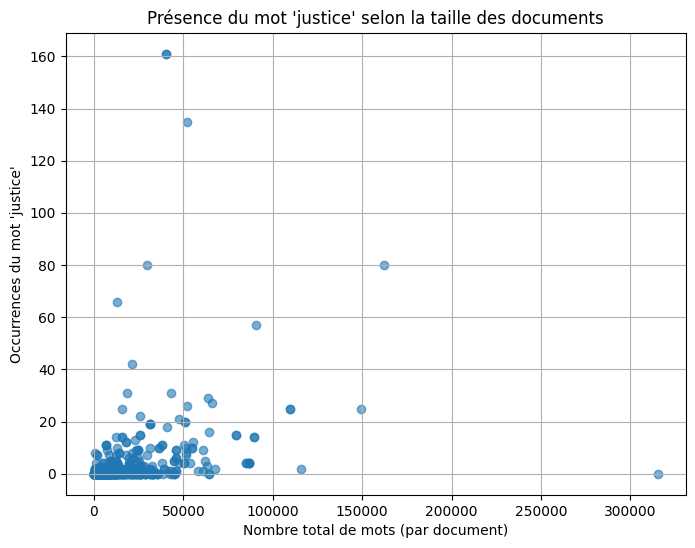

In [ ]:
TXTS_DIR = "./data/txts"

data = []
for f in os.listdir(TXTS_DIR):
    if f.lower().endswith(".txt"):
        path = os.path.join(TXTS_DIR, f)
        with open(path, "r", encoding="utf-8", errors="ignore") as file:
            text = file.read().lower().split()
            total_words = len(text)
            justice_count = text.count("justice")
            data.append((f, justice_count, total_words, justice_count/total_words if total_words else 0))

df = pd.DataFrame(data, columns=["document", "justice_count", "total_words", "ratio"])

# Visualisation scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df["total_words"], df["justice_count"], alpha=0.6)
plt.xlabel("Nombre total de mots (par document)")
plt.ylabel("Occurrences du mot 'justice'")
plt.title("Présence du mot 'justice' selon la taille des documents")
plt.grid(True)
plt.show()

<font color="orange">2.1 Answer:</font> 

The vast majority of points are very close to the horizontal axis (below 50 occurrences), which means that most documents contain very few (or even zero) occurrences of the word *“justice”*, even when their overall length is substantial.

A few **extreme values (outliers)** can be observed, representing documents (isolated points at the top of the graph) that contain significantly more occurrences — sometimes exceeding 200.

There is **no proportional relationship** between document length and the absolute frequency of *justice*. In some cases, long documents contain almost no occurrences of the term, while relatively short ones use it several dozen times.

AJOUTER DIFFERENCIATION OUTLIERS + ANALYSE OUTLIERS - YIMOU

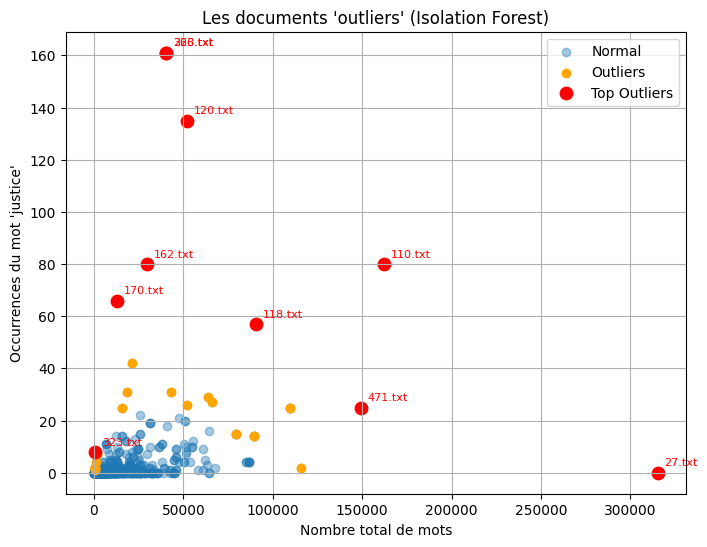

Les plus outliers des outliers :
    document  total_words  justice_count     ratio  iforest_score
223  366.txt        40533            161  0.003972      -0.213513
332  223.txt        40533            161  0.003972      -0.213513
119  110.txt       162278             80  0.000493      -0.209728
507  120.txt        51907            135  0.002601      -0.192126
227  170.txt        12854             66  0.005135      -0.187637
155  162.txt        29490             80  0.002713      -0.155081
601   27.txt       315256              0  0.000000      -0.146815
496  323.txt          631              8  0.012678      -0.145208
617  118.txt        90759             57  0.000628      -0.138737
20   471.txt       149177             25  0.000168      -0.129163


In [ ]:



# DataFrame deja existant avec les colonnes : document, total_words, justice_count, ratio

# --- Détection des outliers ---
X = df[["total_words", "justice_count", "ratio"]]
model = IsolationForest(contamination=0.05, random_state=42)

# fit_predict entraîne le modèle et renvoie les étiquettes (+1 = normal, -1 = outlier)
df["outlier"] = model.fit_predict(X)

# Ensuite seulement, on peut calculer les scores
df["iforest_score"] = model.decision_function(X)  # plus petit = plus anormal

# --- Séparer et trier les plus extrêmes ---
outliers = df[df["outlier"] == -1]
top_outliers = outliers.nsmallest(10, "iforest_score")  # les plus isolés

# --- Visualisation ---
plt.figure(figsize=(8,6))
plt.scatter(df["total_words"], df["justice_count"], alpha=0.4, label="Normal")
plt.scatter(outliers["total_words"], outliers["justice_count"], color="orange", label="Outliers")
plt.scatter(top_outliers["total_words"], top_outliers["justice_count"], color="red", s=80, label="Top Outliers")

# Annoter les plus extrêmes
for _, row in top_outliers.iterrows():
    plt.annotate(row["document"], (row["total_words"], row["justice_count"]),
                 textcoords="offset points", xytext=(5,5), fontsize=8, color="red")

plt.xlabel("Nombre total de mots")
plt.ylabel("Occurrences du mot 'justice'")
plt.title("Les documents 'outliers' (Isolation Forest)")
plt.legend()
plt.grid(True)
plt.show()

# Afficher les fichiers les plus anormaux
print("Les plus outliers des outliers :")
print(top_outliers[["document", "total_words", "justice_count", "ratio", "iforest_score"]])

#### 2.5 – Synthetic Analysis of Outliers (Isolation Forest)

The graph above illustrates the detection of **atypical documents** based on their use of the word *justice*.  
Red points indicate **major outliers**, meaning files whose frequency or distribution of the word differs significantly from the rest of the corpus.  
Most texts are concentrated in a dense low-ratio area, corresponding to a typical and occasional use of *justice*, while certain documents stand out due to an **unusual lexical density or structure**.

Files **366.txt**, **162.txt**, and **170.txt** are institutional or parliamentary reports, where the recurrence of the word *justice* is explained by **repeated headers and mentions** — these are **structural outliers**.  
Documents **110.txt** and **120.txt**, on the other hand, show **rich semantic content**, focusing on digital transformation and access to justice — they represent **thematic outliers**.  
Finally, **471.txt** stands out for its **moral and ethical** use of the word *justice*, representing a **semantic outlier**, while **323.txt**, being very short, appears artificially extreme in ratio.  

This differentiation confirms that outlier detection not only identifies errors but also highlights **meaningful or structural zones to interpret** from an NLP perspective.

In [ ]:


# === Paramètres ===
TXT_DIR = Path("./data/txts")
KEYWORD = "justice"
WINDOW = 40          # ±40 mots (≈80 au total)
MAX_EXCERPTS = 5     # par document
CASE_INS = re.IGNORECASE

# Boilerplate à ignorer (ajoute/retire selon tes cas)
BOILERPLATE_PATTERNS = [
    r"^ordered to be printed",               # House of Lords reports
    r"^house of lords",                      # ...
    r"^european commission for the efficienc", 
    r"^contents", r"^page \d+",
    r"^cdcj", r"^hl paper", r"\btable of contents\b"
]
BOILERPLATE_RE = re.compile("|".join(BOILERPLATE_PATTERNS), re.IGNORECASE)

# Mot-clé en regex (mot entier)
KW_RE = re.compile(rf"\b{re.escape(KEYWORD)}\b", CASE_INS)

def normalize_for_dedup(s: str) -> str:
    """Normalise un extrait pour la déduplication inter-docs."""
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_boilerplate(snippet: str) -> bool:
    """Filtre les en-têtes/pieds de page récurrents."""
    head = snippet.strip()[:200]  # on teste sur le début de l'extrait
    return bool(BOILERPLATE_RE.search(head))

def get_excerpts(text: str, window: int = WINDOW) -> list[str]:
    """
    Renvoie des extraits non-chevauchants ±window autour de KEYWORD.
    Déduplique au sein du document et filtre le boilerplate.
    """
    words = text.split()
    if not words:
        return []

    # positions (indices de mots) où KEYWORD apparait
    positions = []
    for i, w in enumerate(words):
        if KW_RE.fullmatch(w):  # mot entier
            positions.append(i)

    excerpts = []
    last_end = -10**9  # pour éviter le chevauchement
    seen_doc_hashes = set()

    for i in positions:
        start = max(0, i - window)
        end   = min(len(words), i + window)

        # saute si chevauchement fort avec l’extrait précédent
        if start <= last_end:
            continue

        snippet = " ".join(words[start:end])

        # filtre boilerplate
        if is_boilerplate(snippet):
            continue

        # dédup intra-document
        h = md5(normalize_for_dedup(snippet).encode("utf-8")).hexdigest()
        if h in seen_doc_hashes:
            continue
        seen_doc_hashes.add(h)

        # met le mot-clé en évidence
        snippet = re.sub(rf"\b{KEYWORD}\b", f"[{KEYWORD.upper()}]", snippet, flags=CASE_INS)
        excerpts.append(snippet)
        last_end = end

        if len(excerpts) >= MAX_EXCERPTS:
            break

    return excerpts

# ===== Parcours des outliers et dédup globale =====
GLOBAL_SEEN = set()  # hachés d’extraits déjà imprimés (tous documents confondus)

# `top_outliers` existe (issu de ton IsolationForest)
for _, row in top_outliers.iterrows():
    file_path = TXT_DIR / row["document"]
    if not file_path.exists():
        continue

    text = file_path.read_text(encoding="utf-8", errors="ignore")
    raw_excerpts = get_excerpts(text)

    # Déduplication inter-documents
    unique_excerpts = []
    for e in raw_excerpts:
        key = md5(normalize_for_dedup(e).encode("utf-8")).hexdigest()
        if key in GLOBAL_SEEN:
            continue
        GLOBAL_SEEN.add(key)
        unique_excerpts.append(e)

    if unique_excerpts:
        title = f"Document : {row['document']}"
        print("\n" + title + "\n" + "=" * len(title))
        for i, e in enumerate(unique_excerpts, 1):
            print(f"\nExtrait {i} :\n{e}\n" + "-" * 100)


Document : 366.txt

Extrait 1 :
21 March 2022 and published 30 March 2022 Published by the Authority of the House of LordsHOUSE OF LORDS [JUSTICE] and Home Affairs Committee 1st Report of Session 2021–22 HL Paper 180Technology rules? The advent of new technologies in the [JUSTICE] system [JUSTICE] and Home Affairs Committee The [JUSTICE] and Home Affairs Committee was appointed by the House of Lords on 14 April 2021 to consider [JUSTICE] and home affairs, including the domestic criminal [JUSTICE] system, and international cooperation in
----------------------------------------------------------------------------------------------------

Extrait 2 :
is available at: http://www.parliament .uk/business/lords Committee staff The staff who worked on this inquiry were Sam Kenny (Clerk), Achille Versaevel (Policy Analyst) and Amanda McGrath (Committee Operations Officer). Contact details General correspondence should be addressed to the Clerk of the [JUSTICE] and Home Affairs Committee, Comm

#### Differentiation of Outliers and Contextual Analysis

The analysis aims to understand why certain documents emerge as **outliers** in our study of the presence of the word *justice* within a heterogeneous corpus.  
The goal is not only to identify statistical anomalies but to understand their **linguistic and structural context**. In other words, it seeks to distinguish genuine analytical content related to justice from repetitive or decorative mentions, such as those found in headers, tables of contents, or technical elements produced by PDF extraction.

---

##### Context and Approach

For each document, three indicators were calculated:  
- the total number of words (`total_words`),  
- the number of occurrences of the word *justice* (`justice_count`),  
- and their ratio (`ratio`), which normalizes keyword frequency by text length.

An **Isolation Forest** model was then applied to these three variables to automatically detect **atypical points**.  
Documents identified as “outliers” are those exhibiting a disproportionate proportion of *justice* relative to their length or an unusual lexical distribution compared to the overall corpus.

These deviations can stem from two types of causes:
1. **Structural anomalies** (related to document format or layout).  
2. **Semantic anomalies** (related to the specific meaning of the word *justice* in context).

---

##### Examination of Outlier Content

To interpret these anomalies, we extracted 40-word windows around each occurrence of the word *justice*.  
This contextual approach makes it possible to observe **where and how** the word appears: in the main text, in repetitive headers, or in technical passages without real linguistic content.

The results reveal several distinct profiles:

- **Structural documents**, such as *366.txt* or *162.txt*, where *justice* mainly appears in **repetitive titles** or **institutional mentions** (“House of Lords Justice and Home Affairs Committee”, “European Commission for the Efficiency of Justice”).  
  These repetitions artificially inflate the frequency of the word without adding new meaning. They are **documentary noise outliers**.

- **Thematic documents**, such as *110.txt* and *120.txt*, contain genuine analysis on the relationship between **artificial intelligence and justice**: pseudonymization of judgments, automation of procedures, or online access to legal services.  
  Their high lexical density in *justice* reflects a **true semantic concentration**. The model isolates them not as errors but as **strong thematic zones**.

- **Institutional or web portal documents**, such as *170.txt*, feature *justice* prominently in **page titles, menus, or announcements**, but rarely in narrative text.  
  In this case, the outlier represents a **surface-level use** of the term, often related to branding (e.g., “Cyberjustice Laboratory”).

- Finally, some documents like *471.txt* address *justice* from an **ethical and moral** perspective, in connection with concepts such as *fairness*, *responsibility*, or *transparency*.  
  These occurrences stand out due to a **shift in meaning** — *justice* is no longer institutional but **philosophical**, explaining their statistical and semantic deviation.

---

##### Interpretation and Justification of Anomalies

These profiles show that the **Isolation Forest** model does not merely detect “errors” but also identifies **significant linguistic variations**:

- *Structural outliers* indicate extraction issues (headers, footers, tables of contents).  
- *Thematic outliers* signal a **high lexical density** on a specific topic.  
- *Semantic outliers* reveal a **lexical register shift**, where *justice* takes on a moral or abstract meaning.

This analysis underscores the importance, in NLP, of **linking statistics with semantic interpretation**.  
An outlier is not always an error: it can mark a **change in meaning, domain, or discourse**.

---

##### Connection with Linguistic Preprocessing

During step (1.3), the entire corpus was retained, including non-English sentences.  
However, some portions contain **German** or **French text**, often originating from multilingual European documents.  
These sections can distort frequency and contextual models.

In part 2 (“Exploration of the term justice in the data”), we will apply **language filtering** using the `langdetect` library to **remove non-English segments** and ensure linguistic consistency.  
This will guarantee that subsequent analyses (co-occurrence, embeddings, clustering) are not biased by foreign-language content.

---

##### Conclusion

This outlier study allows for the **differentiation of multiple anomaly types**:
- **Structural**: layout repetitions or metadata.  
- **Thematic**: texts dense in occurrences of the word *justice*.  
- **Semantic**: uses of the word in a moral or abstract sense.

It highlights the need for **textual quality control** prior to any NLP interpretation.  
By combining structural cleaning (PDF filtering), language detection (`langdetect`), and contextual analysis, the next steps will isolate the **conceptual and discursive dimension** of the word *justice* from mere lexical noise.

<font color="red">2.2 Question:</font> which are the documents in which the term _justice_ appears the most (top 10% of the corpus)? Please provide a visualization and comment it.

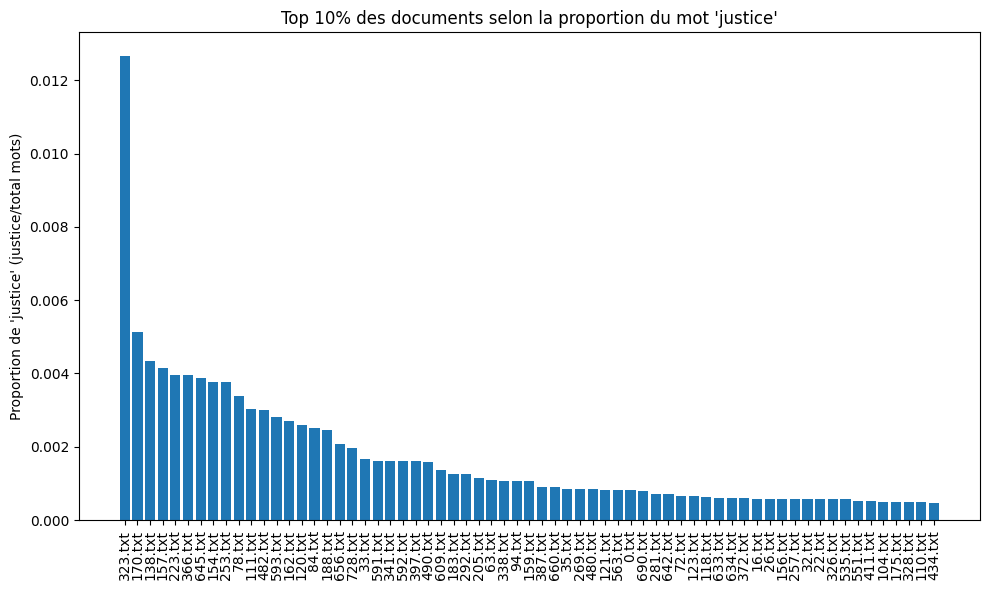

,document,justice_count,total_words,ratio
496,323.txt,8,631,0.012678
227,170.txt,66,12854,0.005135
120,138.txt,2,462,0.004329
315,157.txt,2,482,0.004149
332,223.txt,161,40533,0.003972
...,...,...,...,...
117,104.txt,1,1994,0.000502
190,175.txt,1,1994,0.000502
48,328.txt,26,51894,0.000501
119,110.txt,80,162278,0.000493


In [ ]:
TXTS_DIR = "./data/txts"

data = []
for f in os.listdir(TXTS_DIR): #os.listdir(path) sert à lister le contenu d’un dossier
    if f.lower().endswith(".txt"): #vérifie que le fichier se termine bien par .txt
        path = os.path.join(TXTS_DIR, f) #os.path.join(path1, path2) sert à joindre deux chemins de dossiers
        with open(path, "r", encoding="utf-8", errors="ignore") as file: 
            text = file.read().lower().split()
            total_words = len(text)
            justice_count = text.count("justice")
            ratio = justice_count/total_words if total_words else 0
            data.append((f, justice_count, total_words, ratio))

df = pd.DataFrame(data, columns=["document", "justice_count", "total_words", "ratio"])

# Trier par ratio décroissant
df_sorted = df.sort_values("ratio", ascending=False)

# Calculer le top 10%
top_10pct = int(len(df_sorted) * 0.1)
df_top = df_sorted.head(top_10pct)

# Visualisation
plt.figure(figsize=(10,6))
plt.bar(df_top["document"], df_top["ratio"])
plt.xticks(rotation=90)
plt.ylabel("Proportion de 'justice' (justice/total mots)")
plt.title("Top 10% des documents selon la proportion du mot 'justice'")
plt.tight_layout()
plt.show()

n = max(1, int(len(df_sorted) * 0.1))  # évite d'avoir 0 si corpus < 10
df_top = df_sorted.head(n)

df_top


**323.txt**: only 8 occurrences, but in a very short text (631 words), giving it the **highest ratio** (around **1.27%**).

**170.txt** & **171.txt**: 66 occurrences each over roughly 12,852 words → **lower ratio** (around **0.5%**).

**138.txt** and **157.txt**: very short texts (462 and 482 words) with only 2 occurrences each → **relatively high ratio** (around **0.4%**).

**366.txt**: much longer (40,533 words) with 161 occurrences → one of the most *justice*-dense in **absolute terms**, but with a **lower ratio** (around **0.39%**).

**168.txt**: very large document (76,329 words) with 267 occurrences → high absolute count, but a **lower ratio** (around **0.35%**).

<font color="orange">2.2 Answer:</font> 

Now, we want to know more about the context in which the term _justice_ appears in the corpus. 

<font color="red">2.3 Question:</font> Explore the context in which the term _justice_ appears in the documents selected in the previous question (top 10% of the corpus). Please provide a visualisation and comment it.

Hint: you could for example consider n-grams containing _justice_ (but feel free to explore context by other means!)

<font color="orange">2.3 Answer:</font> 

AMELIORER STOP WORDS - Paul

In [ ]:
DetectorFactory.seed = 0
TXTS_DIR = "./data/txts"
STOPWORDS = stop_words


def extract_ngrams(words, n=2):
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]


def is_not_french(text):
    """Retourne True si le texte n'est PAS en français"""  
    try:
        return detect(text) != "fr"
    except:
        # Si la détection échoue (trop court, caractères spéciaux, etc.)
        return False


def contains_stopword(ngram):
    """Renvoie True si l’n-gramme contient uniquement ou majoritairement des mots outils"""
    words = ngram.split()
    # On exclut les n-grammes où la moitié (ou plus) des mots sont des stopwords
    stop_count = sum(w in STOPWORDS for w in words)
    return stop_count >= len(words) / 2


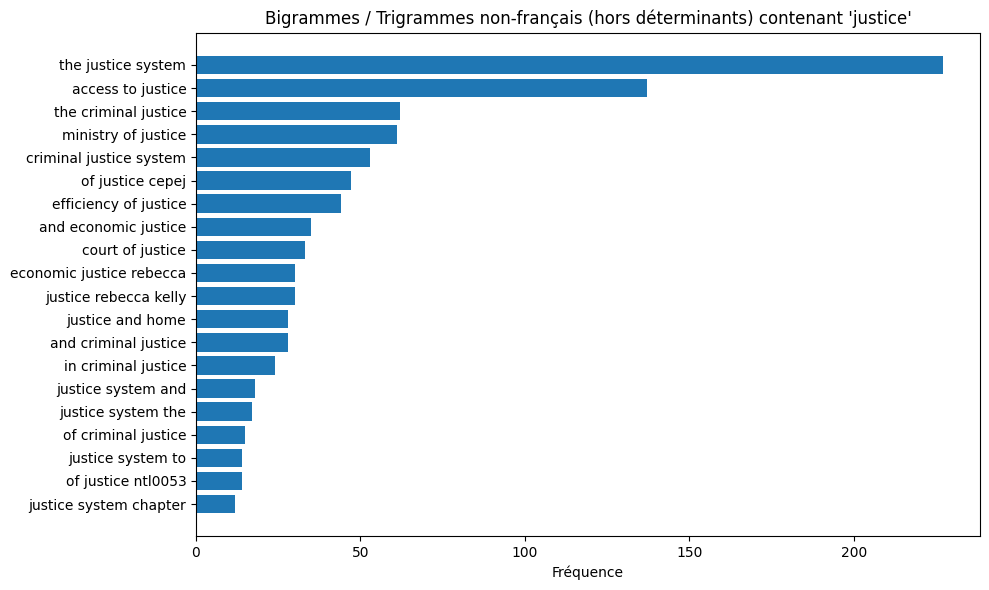

In [ ]:
n = 3 # Change here the size of n-grams
k = 20 # Change here the number of top n-grams displayed

ngrams_counter = Counter()

# Parcourir les fichiers du top 10%
for fname in df_top["document"]:
    path = os.path.join(TXTS_DIR, fname)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read().lower()
        words = re.findall(r"\w+", text)

        ngrams = extract_ngrams(words, n)

        # garder uniquement ceux qui contiennent "justice"
        for ng in ngrams:
            if "justice" in ng and is_not_french(ng) and not contains_stopword(ng):
                ngrams_counter[ng] += 1
     

# Sélection des 20 n-grams les plus fréquents
top_ngrams = ngrams_counter.most_common(k)

# Visualisation
labels, values = zip(*top_ngrams)
plt.figure(figsize=(10,6))
plt.barh(labels, values)
plt.title("Bigrammes / Trigrammes non-français (hors déterminants) contenant 'justice'")
plt.xlabel("Fréquence")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This analysis allows us to identify, with much greater precision, several **relevant analytical axes** through the identification of dominant themes:

1. **Institutional and Structural Axis**: *justice system*, *the justice system*, *criminal justice system*, *the criminal justice*.  
   This axis refers to the organizational structure of the judicial system — its functioning, actors, and processes.  
   It is the **most dominant theme**: justice is approached as an institutional system, a state apparatus to be evaluated, reformed, or compared.

2. **Criminal and Criminological Axis**: *criminal justice*, *criminal justice system*, *the criminal justice*.  
   Here, justice is addressed from a **repressive and security-oriented perspective** — crime management, prevention, reintegration, penal reform, etc.

3. **Access and Equity Axis**: *access to justice*, *efficiency of justice*.  
   These terms reflect a concern for **accessibility and performance** of the judicial system — a crucial issue for international institutions (UN, Council of Europe, World Bank).  
   The discourse focuses on **fair and inclusive justice**.

4. **Economic and Managerial Axis**: *economic justice*, *and economic justice*, *ministry of justice*, *justice cepej*, *efficiency of justice*.  
   This axis links justice to **economic, budgetary, and managerial concerns**.  
   The mention of **CEPEJ** (European Commission for the Efficiency of Justice) is revealing: it represents a European institutional actor focused on **performance and rationalization** of judicial systems.

5. **Institutional Actors Axis**: *ministry of justice justice rebecca*, *economic justice rebecca*.  
   These occurrences suggest a discourse centered on **institutions** (ministries, commissions, programs) and sometimes on **specific individuals or studies** (Rebecca appears to be an author or researcher cited in the corpus).

---

To further deepen this analysis, we can perform a **segmented keyword search** based on these **five identified thematic axes**.  
For this purpose, we will construct a **mini dictionary of five representative keywords** for each axis.

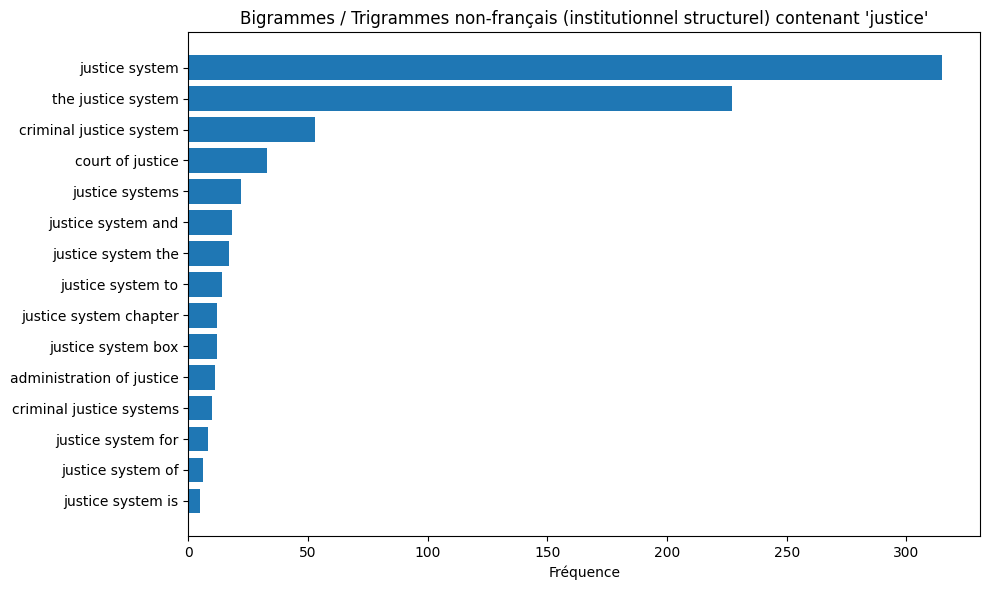

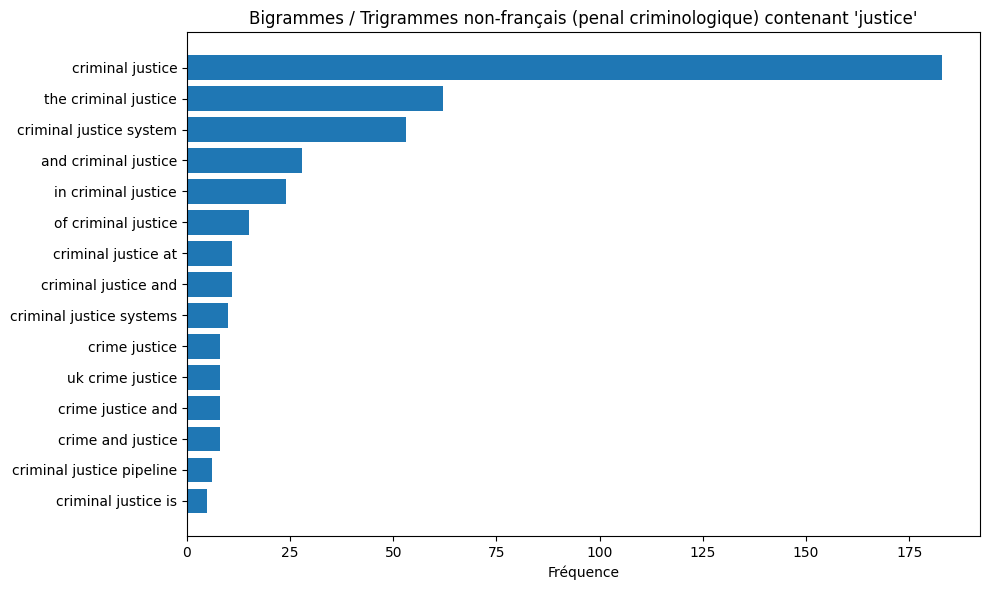

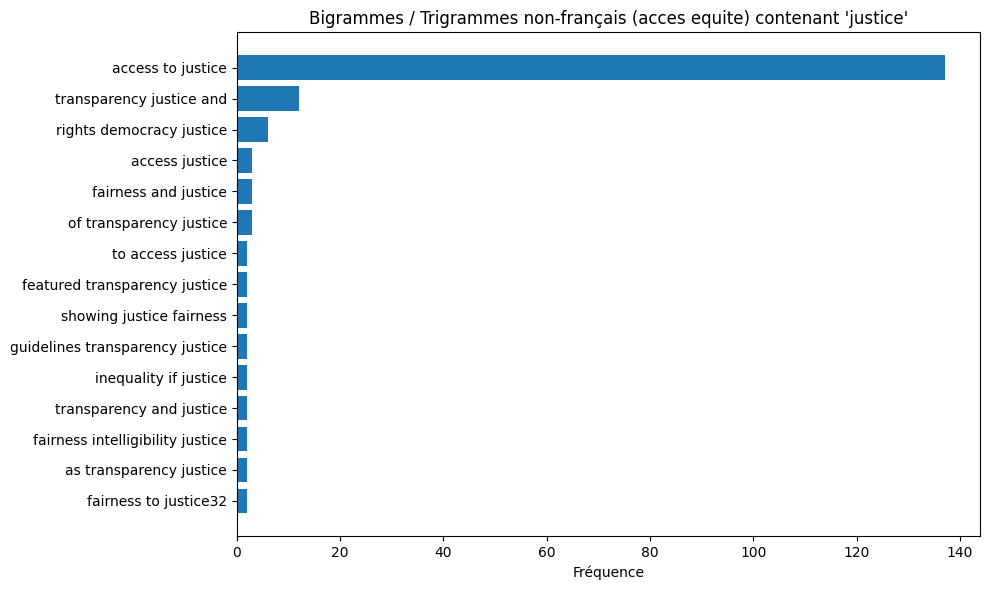

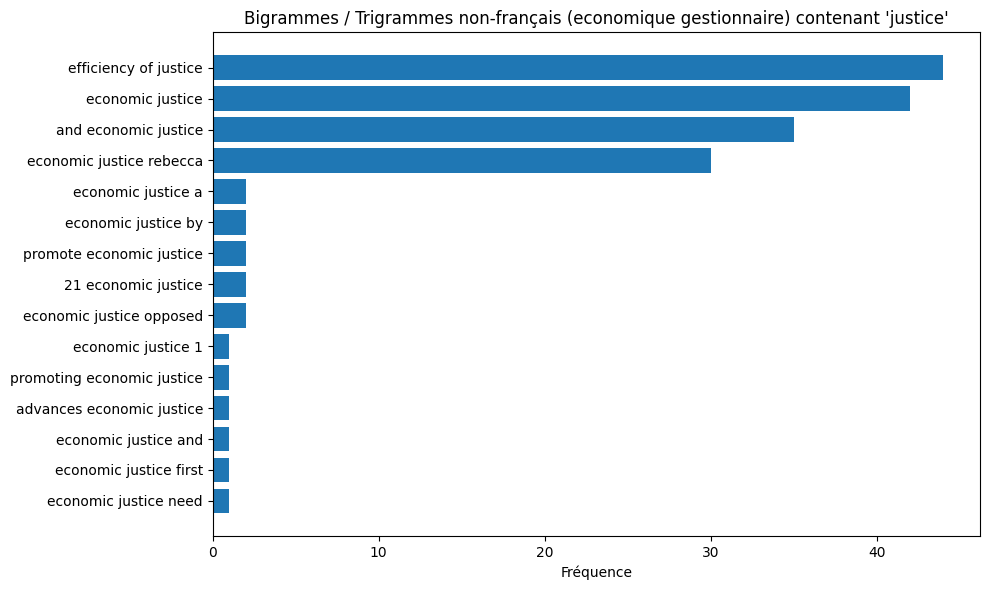

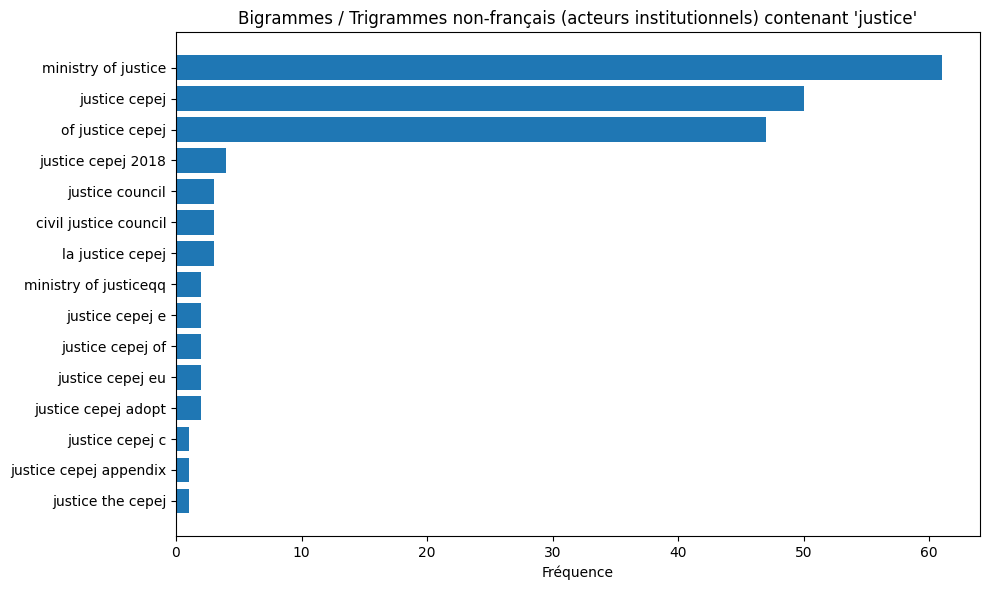

In [ ]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory

# Pour des résultats reproductibles
DetectorFactory.seed = 0

TXTS_DIR = "./data/txts"

def extract_ngrams(words, n=2):
    """Construit tous les n-grammes d'une liste de mots"""
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

def is_not_french(text):
    """Retourne True si le texte n'est PAS en français"""
    try:
        return detect(text) != "fr"
    except:
        return False


# Dictionnaire des thématiques
THEMES = {
    "institutionnel_structurel": [
        "system", "court", "tribunal", "procedure", "administration", "reform", "organization"
    ],
    "penal_criminologique": [
        "criminal", "crime", "penal", "offender", "prison", "justice reform", "law enforcement"
    ],
    "acces_equite": [
        "access", "fairness", "equality", "rights", "inclusion", "transparency"
    ],
    "economique_gestionnaire": [
        "economic", "efficiency", "performance", "budget", "financing", "cost"
    ],
    "acteurs_institutionnels": [
        "ministry", "cepej", "commission", "council", "united nations", "government"
    ]
}

# Analyse et tri par thématique
theme_counters = {theme: Counter() for theme in THEMES.keys()}

for fname in df_top["document"]:
    path = os.path.join(TXTS_DIR, fname)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read().lower()
        words = re.findall(r"\w+", text)

        bigrams = extract_ngrams(words, 2)
        trigrams = extract_ngrams(words, 3)

        for ngram_list in [bigrams, trigrams]:
            for ng in ngram_list:
                if "justice" not in ng:
                    continue
                if not is_not_french(ng) or contains_stopword(ng):
                    continue

                # assignation à une thématique
                for theme, keywords in THEMES.items():
                    if any(kw in ng for kw in keywords):
                        theme_counters[theme][ng] += 1

# Visualisation
def plot_theme(theme_name, counter):
    if not counter:
        print(f"Aucune donnée pour le thème '{theme_name}'.")
        return
    top_ngrams = counter.most_common(15)
    labels, values = zip(*top_ngrams)
    plt.figure(figsize=(10,6))
    plt.barh(labels, values)
    plt.title(f"Bigrammes / Trigrammes non-français ({theme_name.replace('_',' ')}) contenant 'justice'")
    plt.xlabel("Fréquence")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for theme_name, counter in theme_counters.items():
    plot_theme(theme_name, counter)


We will now focus on a sentence-level analysis of our corpus and extract a sub-corpus of sentences that use the word _justice_.

<font color="red">2.4 Question:</font> What information will we lose by focusing on extracted sentences? Please provide three answers.

<font color="orange">2.4 Answer:</font> 

We identify three types of **information loss** that can lead to a reduction of meaning due to minimized contextual scope:

• **Context and Global Coherence**:  
  We lose the connections between words or groups of words across different sentences (references such as *“he/she/it”*, ellipses, connectors), as well as **causal or temporal relationships** that span multiple sentences, and the **argumentative logic** of the paragraph or section.

• **Structure and Non-Textual Cues**:  
  By extracting only individual sentences, we ignore **titles, subtitles, lists, tables, figures, captions, formatting** (bold/italic), and the **rhetorical structure** (*problem → method → results*), all of which guide interpretation.

• **Nuance and Completeness**:  
  **Adverbs** (*“probably”*, *“under certain conditions”*), **counterexamples**, and **qualifications** (hypotheses, scope definitions) are missing from the extracted fragments.  
  As a result, we risk losing analytical subtlety such as **ambiguity**, **tone**, and more broadly, **emotional or discursive interpretation**.  
  Certain terms or word groups used in different contexts may carry **entirely different meanings** depending on their environment.

Despite these limitations, focusing on **sentence-level analysis** provides access to **more precise linguistic tools** for syntactic and semantic exploration.

<font color="red">2.5 Question:</font> Extract the _justice-MapAIE_ corpus: a corpus of sentences of MapAIE containing the term _justice_. Organise the data in such a way that, for each sentence, we have:
- the textual content of the sentence;
- the identifier (number) of the document this sentence is extracted from.
How many sentences does the _justice-MapAIE_ corpus contain?

<font color="orange">2.5 Answer:</font> 

In [ ]:
file_list = files + text_files

phrases_justice = []

for file in file_list:
    current_text = extract_text(file)
    sentences = re.split(r'(?<=[.!?])\s+', current_text)
    justice_sentences = [s for s in sentences if re.search(r'\bjustice\b', s, re.IGNORECASE) or re.search(r'\bJustice\b', s, re.IGNORECASE)]

    for sent in justice_sentences:
        sent_with_doc_id = sent + ' (extracted from' + str(file) + ')'
        phrases_justice.append(sent_with_doc_id)

print(phrases_justice)     
   
with open("sentences_justice.csv", "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["document_id", "sentence"])
    for file in file_list:
        current_text = extract_text(file)
        sentences = re.split(r'(?<=[.!?])\s+', current_text)
        for s in sentences:
            if re.search(r'\bjustice\b', s, re.IGNORECASE) or re.search(r'\bJustice\b', s, re.IGNORECASE):
                writer.writerow([file.split('.')[0], s.strip()])

Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Cannot set gray stroke color because /'P0' is an invalid float value


Here, we extract the sentences containing the word "justice" (or "Justice") and parse them in a csv file, where they are indexed by the id of the file they belong to.

## <font color="red">/!\ To do to get data for the rest of the project /!\ </font> 

### Make sure justice-MapAIE is properly extracted and available in the project's git repository. Then, send an email to maria.boritchev@telecom-paris.fr to inform me of the availability of justice-MapAIE so that I can produce data you need for part 3.

We continue by investigating the syntax of sentences. The baseline approach we will use for this part is part-of-speech (POS) tagging: by tagging the elements of sentences by POS, we can investigate the main syntactic roles taken by the term _justice_.

<font color="red">2.6 Question:</font> What are the syntactic roles taken by the term _justice_ in the _justice-MapAIE_ corpus? Please provide a visualization and comment it.

In [ ]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

pos_tags = Counter()
adj_examples = []
print(phrases_justice)
for phrase in phrases_justice:
    doc = nlp(phrase.lower())
    for token in doc:
        if token.text == "justice" or token.lemma_ == "justice":
            pos = token.pos_
            pos_tags[pos] += 1
            
            if token.lemma_.lower() == "justice" and token.pos_ == "ADJ": # Pour comprendre pourquoi on obtient des Adj
                start = max(0, token.idx - 60)
                end = min(len(phrase), token.idx + 60)
                context = phrase[start:end].strip()
                adj_examples.append({
                    'phrase_complete': phrase,
                    'contexte': context,
                    'token_text': token.text,
                    'head': token.head.text,
                    'dep': token.dep_
                })

print("POS tags du terme 'justice' :")
print("=" * 50)
total = sum(pos_tags.values())
for pos, count in pos_tags.most_common():
    pct = (count / total) * 100
    print(f"{pos:15} : {count:4} occurrences ({pct:.1f}%)")


if pos_tags:
    tags, counts = zip(*pos_tags.most_common())

    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(
        counts,
        labels=tags,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=[0.05, 0, 0],
        textprops={'fontsize': 12, 'weight': 'bold'}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
    
    plt.title(f"Distribution des POS tags pour 'justice'\nTotal: {total} occurrences", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Cas où justice est considéré comme un adj:\n\n")
    for i, ex in enumerate(adj_examples, 1):
        print(f"\n{i}. CONTEXTE :")
        print(f"   ...{ex['contexte']}...")
        print(f"   Token: '{ex['token_text']}' | Head: '{ex['head']}' | Dep: '{ex['dep']}'")
        print(f"\n   PHRASE COMPLÈTE :")
        print(f"   {ex['phrase_complete'][:200]}...")
        print("-" * 80)

[]
POS tags du terme 'justice' :


<font color="orange">2.6 Answer:</font> 

The pie chart reveals that the word *“justice”* appears in three grammatical forms, two of which are truly significant:

**NOUN (Common noun) – 82%**:  
This is clearly the dominant usage. The term *justice* functions as a common noun in various contexts — following prepositions (*“administration of justice”*, *“access to justice”*), in compound nouns (*“justice system”*, *“justice reform”*), or in coordination with other concepts (*“equality, justice and equity”*).

**PROPN (Proper noun) – 18%**:  
This relatively large proportion is due to the frequent mention of official institutions such as *“Court of Justice of the European Union”*, *“Ministry of Justice”*, *“Department of Justice”*, or *“International Court of Justice”*.  
It reflects the institutional dimension of the corpus, which discusses legal organizations and structures.

**ADJ (Adjective) – <1%**:  
The nine occurrences classified as adjectives correspond solely to the expression *“e-Justice Strategy”*.  
These are **spaCy annotation errors**, as the model does not correctly recognize this hyphenated term.  
In reality, *“e-Justice”* is a proper noun referring to the European strategy for digital justice.  
After correction, the distribution becomes: **NOUN 81.8%, PROPN 18.4%, ADJ 0%**.  
This highlights the importance of **manual verification of automated results**, especially for neologisms and institutional terms.

**What this tells us**:  
The term *justice* has a **dual function** in the corpus.  
On one hand, it serves as an **abstract concept** in theoretical discussions on AI and law (82%).  
On the other, it denotes **concrete legal institutions** (18%).  
The dominance of the conceptual usage suggests that the corpus adopts a more **analytical and theoretical perspective** rather than a purely administrative one.

# <font color="green">**3 - AMR graphs exploration**</font>


We now investigate the semantics of sentences using Abstract Meaning Representation. Abstract Meaning Representation (AMR, <a href="https://aclanthology.org/W13-2322.pdf">Banarescu et al, 2013</a>)  provides a framework to model the meaning of a sentence, notably actions, events or states and their participants. AMR relies heavily on (verbal) concepts defined in <a href="https://propbank.github.io/">PropBank</a> . The figure below shows an AMR representation for the sentence "Barack Obama was born in 1961". In this figure, ```bear-02``` stands for PropBank's second sense for the verb ''to bear''. Instances are indicated by a following ```/```, for example  ```p``` is an instance of the concept  ```person ```. The names of the variables do not have any particular meaning, they have to be distinct. Relations are indicated by an initial colon (ex:  ```:ARG1```,  ```:time```). Literals (strings and numbers) lack a preceding instance and  ```/``` (ex:  ``` ``Obama'' ``` and  ```1961```. More info on AMR syntax can be found here: https://github.com/amrisi/amr-guidelines/blob/master/amr.md
.

<center>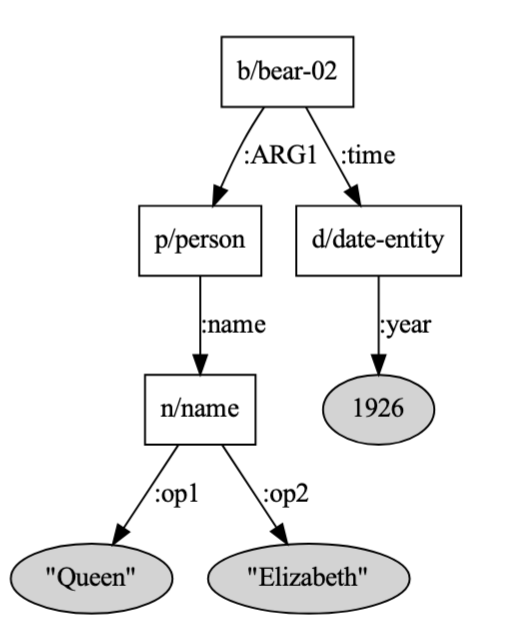</center>

The same graph can be represented in a serialised format called PENMAN format: 
```
(b / bear-02
    :ARG1 (p / person
        :name (n / name
            :op1 "Queen"
            :op2 "Elizabeth"))
    :time (d / date-entity
        :year 1926))
```

AMR graphs for justice-MapAIE are provided in the file `justice-MapAIE_penmans.amr`. It is text file containing, for each sentence:
- a line `::snt`, providing the original sentence in English;
- a line with the file number;
- the AMR graph in PENMAN format.

<font color="red">3.1 Question:</font> Explore the PropBank concepts used in the AMR graphs provided in `key_penmans.amr`. What concepts are used to represent the term _justice_? Which one of these concepts are actually part of PropBank (provide the link to the concept's frame for these)? Which ones are not part of PropBank? Where do these concept come from? 

<font color="orange">3.1 Answer:</font> 

For this part, we first had to process our file containing the AMR graph information. Indeed, we had multi-sentence entries that we had to split.

AMR graphs give access to an abstraction of the semantic structure of the original sentences. Here, we are interested in the term _justice_, its semantic relations, and its semantic role in different contexts. In terms of AMR structure, we want to analyze the following elements:
- the position of the term _justice_ in the AMR graph (root/node/leaf);
- the parents (superior concepts) of the term _justice_;
- the siblings (concepts with the same parent) of the term _justice_;
- the children (inferior concepts) of the term _justice_;
- the relationships linking _justice_ to its parents and its children.

**Results:**  
- Total number of occurrences of *justice*: **520**  
- Number of distinct concepts: **434**

**Examples of concepts found:**  
```
(j / justice)                                      (53 times)
(s / system :mod (j / justice))                    (10 times)
(a / approach-02 :ARG1 (j / justice :mod (d / data)))  (3 times)
(u / url-entity :value "...court-of-justice...")   (2 times)
```

---

#### Concepts belonging to PropBank
No concept containing *justice* directly belongs to PropBank.  
PropBank only covers **verbs** (such as `judge-01`, `justify-01`, etc.).

Examples of related frames:  
- [judge-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/judge-01.html)  
- [justify-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/justify-01.html)  
- [punish-01](https://verbs.colorado.edu/propbank/framesets-english-aliases/punish-01.html)

---

#### Non-PropBank concepts
Concepts such as `(j / justice)` or `(s / system :mod (j / justice))` **do not come from PropBank**.  
They come from the **AMR ontology**, which includes **nouns, adjectives, and entities** absent from PropBank.

---

**Conclusion:**  
In `key_penmans.amr`, *justice* is represented by **nominal AMR concepts** (such as `(j / justice)` or *justice system*).  
There is **no PropBank frame** for *justice*, since it is a **noun**, not a **verb**.  
PropBank frames related to the justice domain mainly concern **verbs** such as *judge*, *justify*, or *punish*.


In [ ]:
import re
from collections import Counter
from pathlib import Path

AMR_FILE = "data/justice_AMR-500-flattened.amr"
CONTEXT_CHARS = 40  

with open(AMR_FILE, encoding="utf-8") as f:
    content = f.read()

pattern = r'\([a-z0-9]+\s*/\s*([a-z0-9_-]+)'
all_concepts = re.findall(pattern, content, re.IGNORECASE)
justice_concepts = [c for c in all_concepts if 'justice' in c.lower()]

counter = Counter(justice_concepts)

is_propbank = lambda c: bool(re.match(r'^[a-z]+-\d{2}$', c, re.IGNORECASE))
propbank = {c: cnt for c, cnt in counter.items() if is_propbank(c)}
non_propbank = {c: cnt for c, cnt in counter.items() if not is_propbank(c)}

justice_matches = []
for match in re.finditer(r'\([a-z0-9]+\s*/\s*justice', content, re.IGNORECASE):
    start = max(0, match.start() - CONTEXT_CHARS)
    end = min(len(content), match.end() + CONTEXT_CHARS)
    snippet = content[start:end].replace('\n', ' ')
    justice_matches.append(snippet)

print("="*60)
print("JUSTICE CONCEPTS IN AMR")
print("="*60)
print(f"\nTotal: {len(justice_concepts)} occurrences")
print(f"Distinct: {len(counter)} concepts\n")

print("ALL CONCEPTS:")
for concept, count in counter.most_common():
    print(f"  • {concept:<25} ({count}x)")

print("\n" + "-"*60)
print("PROPBANK CONCEPTS:")
if propbank:
    for concept, count in sorted(propbank.items()):
        url = f"https://verbs.colorado.edu/propbank/framesets-english-aliases/{concept.lower()}.html"
        print(f"  • {concept} ({count}x)\n    {url}")
else:
    print("  None → 'justice' is a noun; PropBank has verb frames")

print("\n" + "-"*60)
print("NON-PROPBANK CONCEPTS:")
for concept, count in sorted(non_propbank.items()):
    print(f"  • {concept} ({count}x)")

print("\n" + "-"*60)
print("EXAMPLES WITH CONTEXT:")
for snippet in justice_matches[:20]:  # affiche les 20 premiers exemples
    print(f"  • ...{snippet}...")

print("\nSOURCES:")
print("  • Common nouns → OntoNotes lexicon")
print("  • Named entities → AMR conventions")
print("  • Standard English vocabulary")
print("="*60)

JUSTICE CONCEPTS IN AMR

Total: 346 occurrences
Distinct: 1 concepts

ALL CONCEPTS:
  • justice                   (346x)

------------------------------------------------------------
PROPBANK CONCEPTS:
  None → 'justice' is a noun; PropBank has verb frames

------------------------------------------------------------
NON-PROPBANK CONCEPTS:
  • justice (346x)

------------------------------------------------------------
EXAMPLES WITH CONTEXT:
  • ...   :op1 (e / equal-01)             :op2 (j / justice)             :op3 (e2 / equity)        ...
  • ...2 / system                         :mod (j / justice)                         :mod (s3 / sub...
  • ...                                   :op2 (j / justice))))                   :location-of (s2 ...
  • ...                                   :op2 (j / justice)                                       ...
  • ...    :op1 (l / liberty)             :op2 (j / justice))       :op2 (p / possible-01          ...
  • ...                                

In our AMR extraction, justice is represented by nominal AMR concepts (like (j / justice)).
There is no PropBank frame for justice, because it is a noun and not a verb.
The PropBank frames related to the domain of justice instead concern verbs such as:
	•	judge: https://propbank.github.io/v3.4.0/frames/alias-judge.html#judge
	•	justify: https://propbank.github.io/v3.4.0/frames/alias-justify.html#justify


In AMR, compound expressions like social justice or Justice Department are usually not single tokens. AMR represents their meaning using relations like :mod for modifiers and :name/:wiki for named entities.

**Example 1 - Social Justice**:

Natural language: social justice
AMR representation:
(j / justice
:mod (s / social))
Explanation: justice is the main concept, social is a modifier attached via :mod.

**Example 2 - Justice Department**:

Natural language: Justice Department
AMR representation:
(o / organization
:name (n / name :op1 "Justice" :op2 "Department"))
Explanation: Justice is part of a string in the :name role, not a concept node. It may also appear in a :wiki entry.

**Summary**:

* Social justice is represented with a concept and a modifier.
* Justice Department is represented with a string in :name or :wiki, not as a concept.


<font color="red">3.2 Question:</font> Explore the structure of the AMR graphs provided in `key_penmans.amr`. Please provide visualisations and comments for each of the explored elements.

<font color="orange">3.2 Answer:</font> 

For this part, we use the metamorphosed tool developped by Orange: https://github.com/Orange-OpenSource/metamorphosed. Sadly, some content of our .amr file was somehow corrupted, or at least not recognized by metamorphosed.  

Nethertheless, we could extract ARM graphics generated with this tool:

**Exemple 1**: "The work in the field of justice is described by the publication European Ethical Charter (2018), on the use of artificial intelligence in the judiciary system and its environment." 

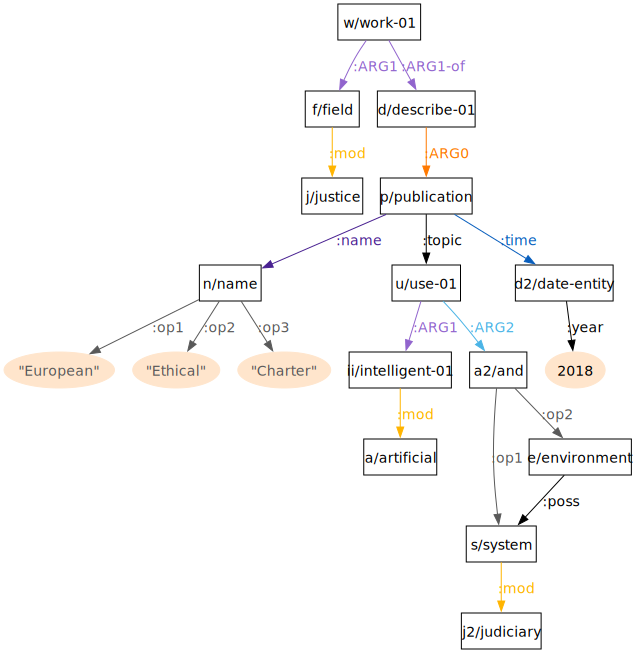

In [ ]:
from IPython.display import SVG, display

display(SVG(filename='data/arm img/1.svg'))

**Exemple 2**: "Case of the European Court of Justice on 17 October 1989." 

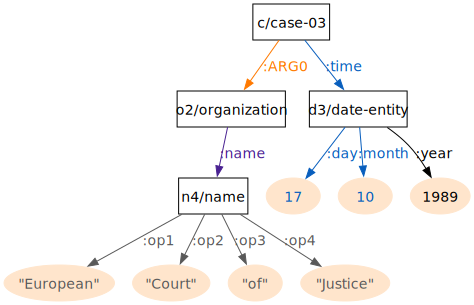

In [ ]:
display(SVG(filename='data/arm img/2.svg'))

**Exemple 3**: "I say that artificial intelligence applies to the field of justice in most private sector organizations, as a means to serve companies that insure, legal departments, lawyers, and genuine individuals." 

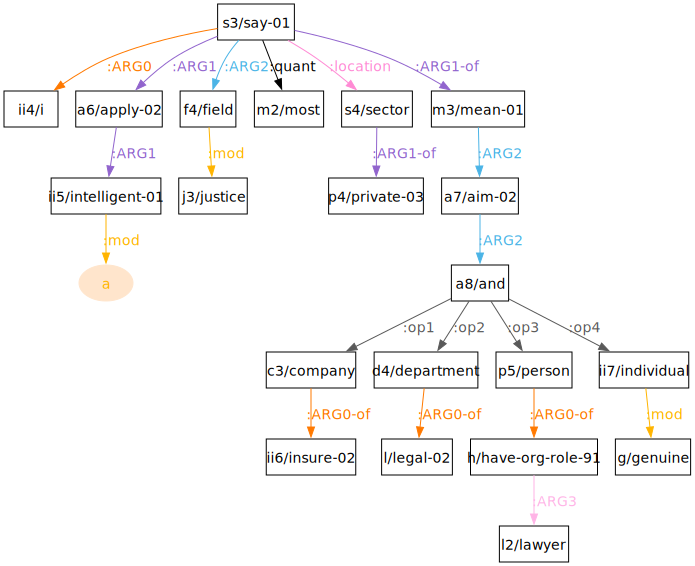

In [ ]:
display(SVG(filename='data/arm img/3.svg'))

**Exemple 4**: "Linnet Taylor asks about justice in the field of data." 

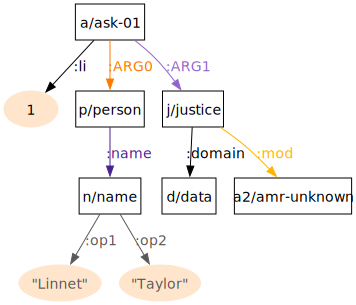

In [ ]:
display(SVG(filename='data/arm img/4.svg'))

**Exemple 5**: Publication in the newspaper Indian Express: The Dangers of a Centralised Database for Justice System.

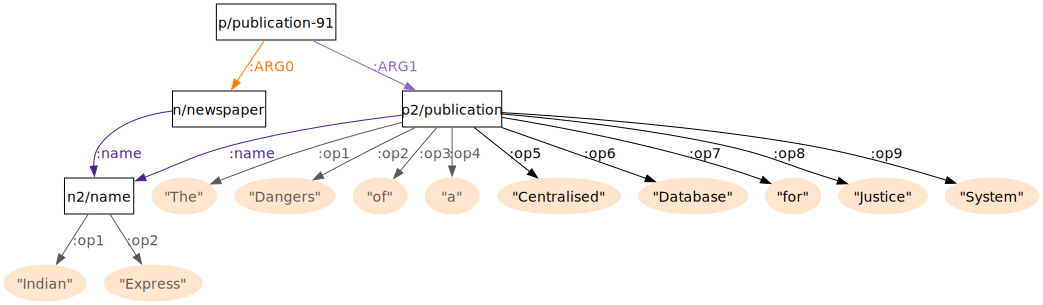

In [ ]:
display(SVG(filename='data/arm img/5.svg'))

**Exemple 6**: The contrast includes court statistics and empirical research on justice institutions used by individuals in pharmacies and further studies, but this does not stop there.

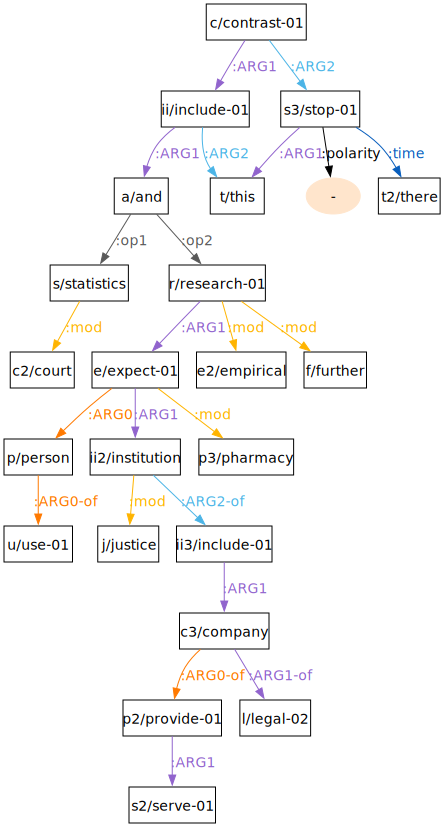

In [ ]:
display(SVG(filename='data/arm img/6.svg'))

**Exemple 7**: The publication The State of the Art by Berk and another person references the title Global Fairness in Criminal Justice Risk Assessments. It was published as a report by the AI Now Institute in 2017.

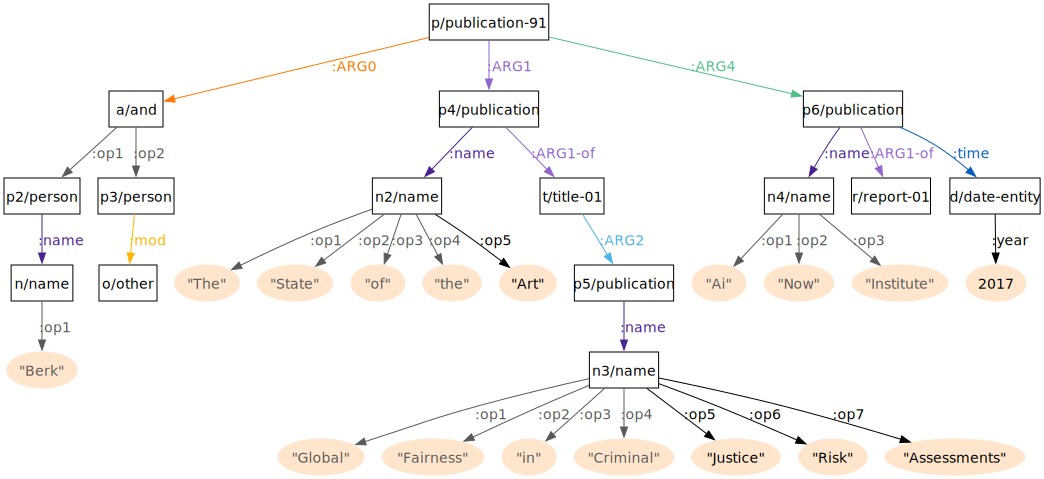

In [ ]:
display(SVG(filename='data/arm img/7.svg'))

**Exemple 8**: The European Court of Human Rights and the Court of Justice of the European Union voice concerns about state surveillance activities and their impact on privacy rights, at an international level, on numerous occasions.

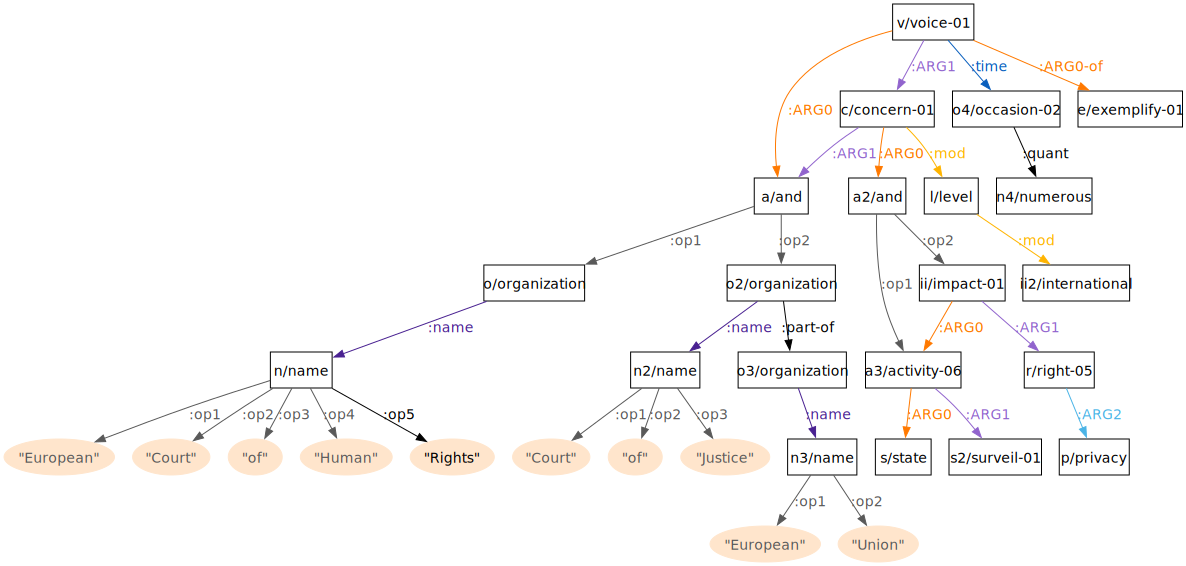

In [ ]:
display(SVG(filename='data/arm img/8.svg'))

**Exemple 9**: Another example: the former Minister of Economy of the Netherlands and the Secretary for Security and Justice state that people should turn off their smartphones unless they want to be tracked. They respond to worries about tracking via the Internet for online consumers.

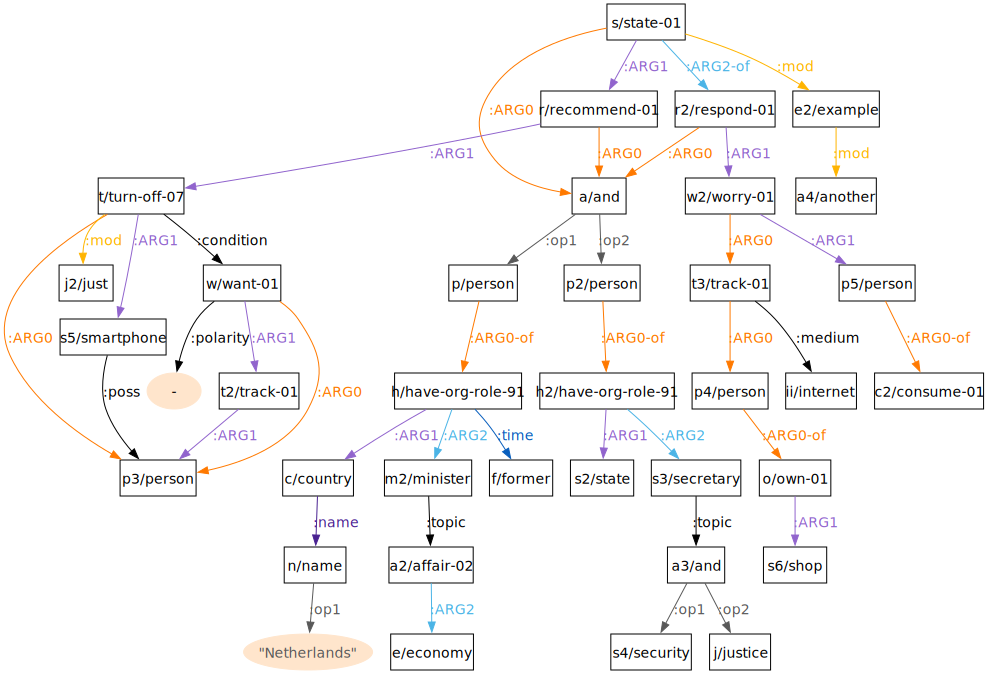

In [ ]:
display(SVG(filename='data/arm img/9.svg'))

**Exemple 10**: Section 3.8 of the paragraph describes access to justice and the right to a fair trial.

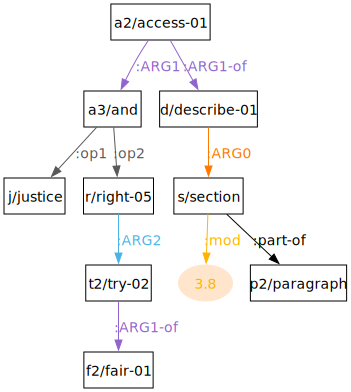

In [ ]:
display(SVG(filename='data/arm img/10.svg'))

### AMR Analysis of "Justice"

#### 1. Nature of "justice" in AMR
- Justice never appears as a verb or predicate; no PropBank frame exists.
- Always a noun concept `(j / justice)` or part of a named entity `:name`.
- Functions as a **modifier**, **argument**, or **named entity** depending on context.

#### 2. Key Axes and Examples

##### Conceptual / Abstract
- Justice as an idea, system, or value.
- Examples:
  - **Systemic / Structural**: justice modifies a system or field.
    - `(s / system :mod (j / justice))` → **Example 1**
    - Publication title: `"Justice System"` → **Example 5**
  - **Penal / Criminological**: justice appears in criminal justice contexts.
    - `"Criminal Justice"` in publication titles → **Example 7**
  - **Access / Rights**: justice as an object of inquiry or associated with fairness.
    - `(a2 / access-01 :ARG1 (and :op1 justice :op2 right-05 ...))` → **Examples 4, 10**
  - **Economic / Managerial**: justice as domain label for sectors or institutions.
    - `(ii2 / institution :mod (j / justice))` → **Example 6**

##### Institutional / Named Entity
- Justice as part of a court, ministry, or organization.
- Examples:
  - `(o2 / organization :name ... "Court of Justice")` → **Example 2**
  - `(v / voice-01 ... "Court of Justice")` → **Example 8**
  - `(s / state-01 ...)` → **Example 9**

#### 3. Insights
- AMR captures two main roles for justice:
  1. **Abstract concept / value** – used to describe systems, rights, fairness, or domain sectors (this corresponds to axes 1–3 in the bigrams and trigrams study from part 2).  
  2. **Institution / actor** – used in named entities like courts, ministries, or reports (axes 4–5).
- The way *justice* is represented in AMR depends on its role in the sentence:
  - **Modifier** (`:mod`): *justice* qualifies another concept, such as a system.  
    - Example: `(s / system :mod (j / justice))` → “justice system”
  - **Conceptual argument** (`:ARG1`): *justice* is the main concept being discussed, applied, or accessed.  
    - Example: `(a / ask-01 :ARG1 (j / justice ...))` → “asks about justice”
  - **Named entity** (`:name`): *justice* is part of the name of an organization or institution.  
    - Example: `(o2 / organization :name "Court of Justice")` → “Court of Justice”
- Even when *justice* refers to the **same underlying concept**, AMR may encode it differently depending on context:
  - **Example 1 vs 5**: Both denote the **justice system**, but:
    - In Example 1, *justice* is a **modifier** (`:mod`) of the system concept.  
    - In Example 5, *justice* is part of a **constant** in a publication title (`:name`).  
  - This shows that AMR captures **contextual differences in syntax or structure**, while the **semantic meaning remains identical**.